# Breast Cancer Detection Classifiers Trained on UCI Breast Cancer Wisconsin Diagnostic Dataset

In [89]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [14]:
from ucimlrepo import fetch_ucirepo
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets.values.ravel()

# metadata
# print(breast_cancer_wisconsin_diagnostic.metadata)
# Diagnosis (M = malignant, B = benign)
  
# variable information 
# print(breast_cancer_wisconsin_diagnostic.variables) 

In [48]:
def evaluate_model(y_test, y_pred):
    eval = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred, target_names=np.array(['malignant', 'benign'], dtype='<U9'))
    }
    return eval

def print_eval_report(eval):
    print('Accuracy: ', round(eval['accuracy'], 3))
    print('Precision: ', round(eval['precision'], 3))
    print('Recall: ', round(eval['recall']))
    print('F1 Score: ', round(eval['f1_score'], 3))
    print('\nConfusion Matrix:\n ', eval['confusion_matrix'])
    print('\nClassification Report:\n ', eval['classification_report'])

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

scaler = StandardScaler()
le = LabelEncoder()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

## Logistic Regression

We'll begin with a logistic regression model. This model provides a linear boundary which minimizes the logistic loss function $\sum_{k=1}^N -y_k \ln p(x_k) - (1-y_k)\ln(1 - p(x_k))$ for $p(x_1,...,x_n) = (1 + \exp(-(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)))$. Additionally to help with overfitting we include an $\ell_2$ penalty term $1/C \sum_{i = 0}^n \beta_i^2$. The parameter $C$ will be selected by training and evaluating with multiple values.

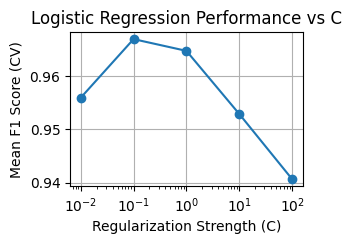

In [92]:
lr_param_grid = {
    'C' : [0.01, 0.1, 1, 10, 100],
    'penalty' : ['l2'],
    'solver' : ['liblinear'],
    'max_iter' : [1000]
}

lr_grid = GridSearchCV(LogisticRegression(), lr_param_grid, cv=5, scoring='f1')
lr_grid.fit(X_train_scaled, y_train)

lr_param_results = pd.DataFrame(lr_grid.cv_results_)
lr_scores = lr_param_results['mean_test_score']

plt.figure(figsize=(3,2))
plt.plot(lr_param_grid['C'], lr_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score (CV)')
plt.title('Logistic Regression Performance vs C')
plt.grid(True)
plt.show()

In [84]:
lr_model = LogisticRegression(
    C = 0.1,
    penalty = 'l2',
    solver = 'liblinear',
    max_iter = 1000
)

lr_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [85]:
lr_y_pred = lr_model.predict(X_test_scaled)
lr_eval = evaluate_model(y_test, lr_y_pred)
print_eval_report(lr_eval)

Accuracy:  0.956
Precision:  0.909
Recall:  1
F1 Score:  0.941

Confusion Matrix:
  [[69  4]
 [ 1 40]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.99      0.95      0.97        73
      benign       0.91      0.98      0.94        41

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



### Support Vector Machine

The next model we will train is an support vector machine classifier. Unlike logistic regression, SVM classifiers can support nonlinear decision boundaries depending on the choice of kernel, though they may take longer to train and be more prone to overfitting. Our PCA plot generated in the visualization section of this project suggests that a linear kernel will be sufficient for this dataset. 

While both SVM and logisitic regression produce linear decision boundaries, SVM maximizes the margin, i.e. distance from the boundary to the closest points. This provides better performance for datapoints near the boundary. Once again we will train and evaluate multiple values of $C$ to find the optimal parameter.

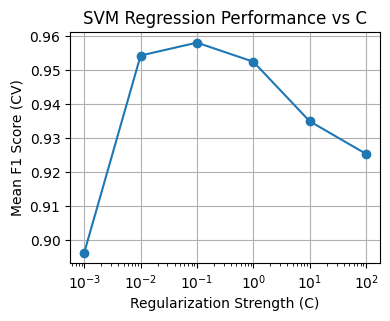

In [97]:
svm_param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['linear']
}

svm_grid = GridSearchCV(SVC(), svm_param_grid, cv=5, scoring='f1')
svm_grid.fit(X_train_scaled, y_train)

svm_param_results = pd.DataFrame(svm_grid.cv_results_)
svm_scores = svm_param_results['mean_test_score']

plt.figure(figsize=(4,3))
plt.plot(svm_param_grid['C'], svm_scores, marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Mean F1 Score (CV)')
plt.title('SVM Regression Performance vs C')
plt.grid(True)
plt.show()

In [98]:
svm_model = SVC(kernel='linear', C=1.0, random_state=28)
svm_model.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [99]:
svm_y_pred = svm_model.predict(X_test_scaled)
svm_eval = evaluate_model(y_test, svm_y_pred)
print_eval_report(svm_eval)

Accuracy:  0.956
Precision:  0.909
Recall:  1
F1 Score:  0.941

Confusion Matrix:
  [[69  4]
 [ 1 40]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.99      0.95      0.97        73
      benign       0.91      0.98      0.94        41

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



## Random Forest


In [51]:
rf_model = RandomForestClassifier(random_state=28)
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [55]:
rf_y_pred = rf_model.predict(X_test)
rf_eval = evaluate_model(y_test, rf_y_pred)
print_eval_report(rf_eval)

Accuracy:  0.939
Precision:  0.905
Recall:  1
F1 Score:  0.916

Confusion Matrix:
  [[69  4]
 [ 3 38]]

Classification Report:
                precision    recall  f1-score   support

   malignant       0.96      0.95      0.95        73
      benign       0.90      0.93      0.92        41

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



In [17]:
importances = rf.feature_importances_
features_names = X.columns

## Neural Network

## Analysis